In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch

# Rand reps, model init fixed

In [2]:
import sys
sys.path.append('../../')

import denn.utils as ut

In [3]:
# folder = lambda i: f"/Users/dylanrandle/Downloads/POS_run_gan_053020_seed{i}/val_mse.npy"
# gan_reps = []
# for i in range(5):
#     gan_reps.append(np.load(folder(i)))
# gan_reps = np.vstack(gan_reps)

In [3]:
# gan_reps = np.load('/Users/dylanrandle/Downloads/pos_reps_052620_gan.npy')

gan_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/wav/wav_rand_reps_gan.npy')

l2_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/wav/wav_rand_reps_L2.npy')

l1_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/wav/wav_rand_reps_L1.npy')

huber_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/wav/wav_rand_reps_huber.npy')

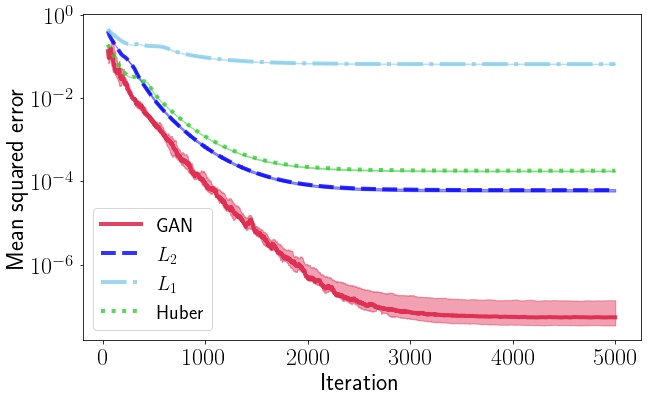

In [5]:
arrs_dict = {"GAN": gan_reps, 
             "$L_2$": l2_reps,
             "$L_1$": l1_reps, 
             "Huber": huber_reps,
#              "RK4": mse*np.ones_like(huber_reps)
            }
ut.plot_reps_results(arrs_dict, fname="wav_rand_reps.png",
                     window=50, figsize=(10,6), pctiles=(25,75), linewidth=4)

In [6]:
print(f"L1 Min: {np.min(l1_reps)}")
print(f"L2 Min: {np.min(l2_reps)}")
print(f"Huber Min: {np.min(huber_reps)}")
print(f"GAN Min: {np.min(gan_reps)}")

L1 Min: 0.06270967423915863
L2 Min: 4.466272366698831e-05
Huber Min: 0.00015940068988129497
GAN Min: 1.5185051438493247e-08


# Finite Diff

In [3]:
dx=1/32
dt=1/32
tmin=0.0
tmax=1.0
xmin=0.0
xmax=1.0
c=1.0
rsq=(c*dt/dx)**2

nx = int((xmax-xmin)/dx) + 1
nt = int((tmax-tmin)/dt) + 2
u = np.zeros((nx,nt))

# initial condition
def initial_cond(x):
    val = np.sin(np.pi * x)
    return val

for x in range(0,nx):
    u[x,0]=initial_cond(xmin+x*dx)
    u[x,1]=u[x,0]

# finite difference update
for t in range(1, nt-1):
    for x in range(1,nx-1):
        u[x,t+1] = 2*(1-rsq)*u[x,t]-u[x,t-1]+rsq*(u[x-1,t]+u[x+1,t])

In [4]:
x = np.linspace(xmin, xmax, nx)
t = np.linspace(tmin, tmax, nt)
xx, tt = np.meshgrid(x, t)

In [5]:
u.shape, xx.shape, tt.shape

((33, 34), (34, 33), (34, 33))

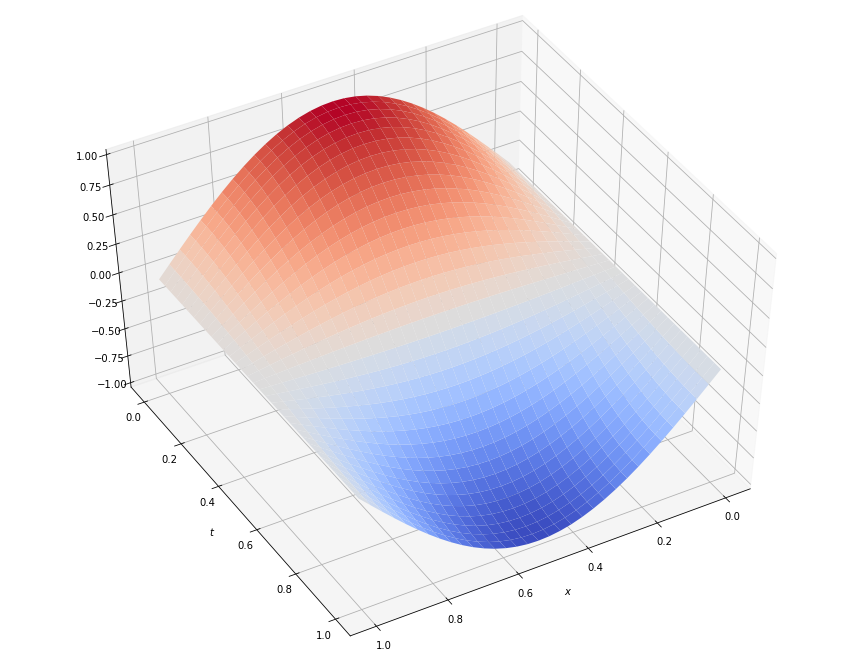

In [6]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection="3d")
ax.plot_surface(xx, tt, u.T, cmap=cm.coolwarm, rcount=500, ccount=500)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.view_init(elev=50, azim=60)
plt.show()

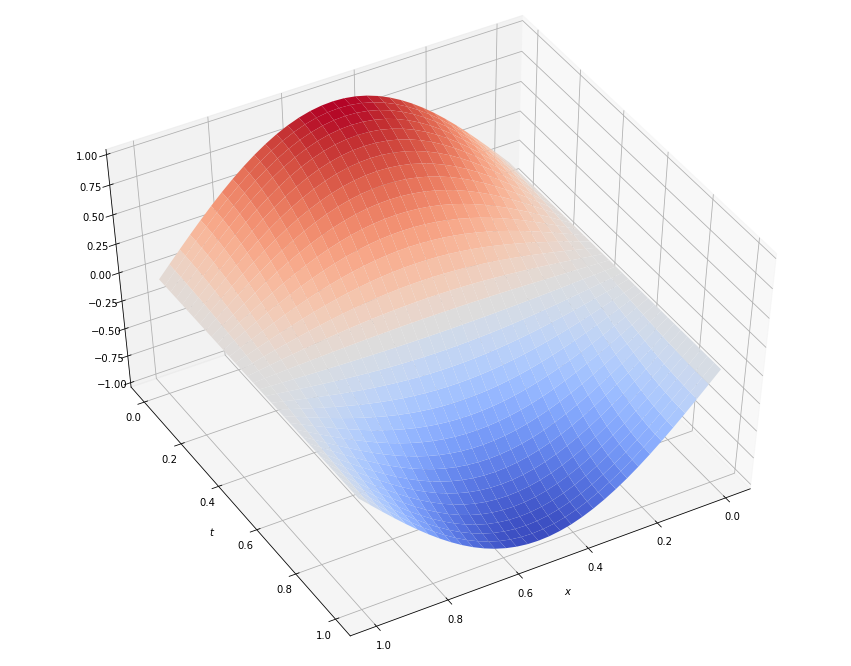

In [7]:
u_analit = np.cos(1*np.pi*tt)*np.sin(np.pi*xx)
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection="3d")
ax.plot_surface(xx, tt, u_analit, cmap=cm.coolwarm, rcount=500, ccount=500)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.view_init(elev=50, azim=60)
plt.show()

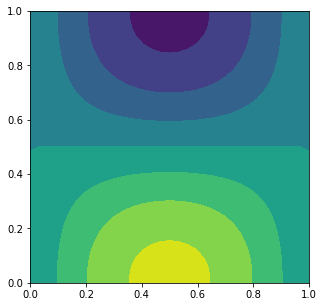

In [8]:
plt.figure(figsize=(5,5))
plt.contourf(xx, tt, u.T)

In [9]:
np.mean((u.T - u_analit)**2)

7.975025275131646e-05